In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn import metrics

In [3]:
PATH = 'data/plant_seedlings/'
sz = 256
arch = resnet34
bs = 64

In [4]:
is_val = True

<h3>Creating a validation set</h3>

Back up the files, create two new directories for both training and validation data by splitting the original data by 20%

In [5]:
# prep directory for selection
val_train = os.path.join(PATH, 'val_train')
valid = os.path.join(PATH, 'valid')
if os.path.exists(val_train):
    shutil.rmtree(val_train)
if os.path.exists(valid):
    shutil.rmtree(valid)

shutil.copytree(os.path.join(PATH, 'train'), val_train)
os.mkdir(valid)

# get random 20% of images
percentage = .2
catas = list(map(lambda x: os.path.join(val_train, x), os.listdir(val_train)))
shuffled_files = list(map(lambda x: random.sample(x, len(x)), map(os.listdir, catas)))
percent_files = list(map(lambda x: x[:(math.ceil(len(x) * percentage))], shuffled_files))
concat_files = list(map(lambda x: list(map(lambda y: os.path.join(x[0], y), x[1])), zip(catas, percent_files)))
val_files = list(x for y in concat_files for x in y)

# move val_files to valid directory
new_files = list(map(lambda x: os.path.join(valid, x), map(lambda y: os.path.join(os.path.basename(os.path.dirname(y)), os.path.basename(y)), val_files)))
for x in set(map(lambda y: os.path.basename(os.path.dirname(y)), val_files)) : os.mkdir(os.path.join(valid, x))
for x in list(zip(val_files, new_files)) : os.rename(x[0], x[1])

<h3>First model</h3>

If validation is not needed (for submissions), just use the regular train folder with all the data since we don't care for validation

In [6]:
train_name = 'val_train' if is_val else 'train'
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, trn_name=train_name, test_name='test', tfms=tfms, bs=bs)
    
    return data

In [7]:
data = get_data(sz, bs)

In [8]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 60/60 [00:23<00:00,  2.54it/s]


Let's find a good learning rate

In [9]:
lrf=learn.lr_find()

 75%|███████▌  | 45/60 [00:01<00:00, 36.63it/s, loss=22.1]


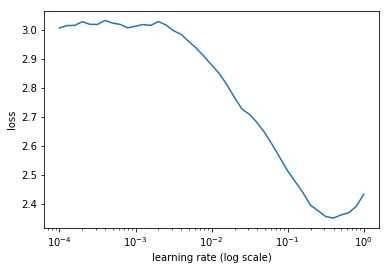

In [10]:
learn.sched.plot()

Looks like 1e-1, but 1e-2 works better

In [11]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.464118   0.757366   0.740586  
    1      0.996583   0.54674    0.829498                  
    2      0.793968   0.459022   0.853556                  
    3      0.677346   0.393069   0.875523                  
    4      0.608133   0.356684   0.888075                  



[array([0.35668]), 0.8880753133087478]

<h3>Data augmentation</h3>

Turn off precompute so our augmentation can take place

In [12]:
learn.precompute = False

In [13]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.666174   0.510339   0.848326  
    1      0.633044   0.495907   0.841004                  
    2      0.608456   0.481942   0.846234                  
    3      0.609017   0.482558   0.848326                  
    4      0.582205   0.481294   0.851464                  



[array([0.48129]), 0.8514644338994845]

In [14]:
learn.save('256_pre')

In [15]:
learn.load('256_pre')

For the last few layers, let's try to increase our image size a bit for extra augmentation

In [16]:
learn.set_data(get_data(math.ceil(sz * 1.2), bs))
learn.freeze()

In [17]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.592374   0.414542   0.868201  
    1      0.548763   0.414296   0.877615                  
    2      0.528481   0.408322   0.875523                  



[array([0.40832]), 0.8755230110559503]

Data is not being overfitted, so let's try to push it a bit more

In [18]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.52233    0.391008   0.881799  
    1      0.511363   0.381417   0.881799                  
    2      0.496555   0.377812   0.878661                  
    3      0.479809   0.389835   0.878661                  
    4      0.466406   0.371901   0.887029                  
    5      0.456512   0.370851   0.878661                  
    6      0.431268   0.369887   0.884937                  



[array([0.36989]), 0.884937239740683]

Looks good, let's enable test time augmentation

In [19]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9079497907949791, 0.3548567427210467)

In [20]:
learn.save('256*1.2_pre')

In [21]:
learn.load('256*1.2_pre')

Let's run a few more epochs for giggles

In [22]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.429036   0.359889   0.885983  
    1      0.425415   0.356604   0.888075                  



[array([0.3566]), 0.8880753150544904]

In [23]:
learn.save('256*1.2_pre')

In [24]:
learn.load('256*1.2_pre')

In [25]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9016736401673641, 0.3468338000750038)

In [26]:
learn.save('256*1.2_pre')

In [27]:
learn.load('256*1.2_pre')

<h3>Fine tuning</h3>

Let's do some differential learning rate annealing, but first the data is too large, and cuda runs out of memory on my machine, so let's shrink it a bit

In [28]:
learn.set_data(get_data(math.ceil(sz * 0.8), bs))

In [29]:
learn.unfreeze()

In [30]:
lr=np.array([1e-4,1e-3,1e-2])

In [31]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.662506   0.420527   0.857741  
    1      0.44002    0.286312   0.900628                  
    2      0.310082   0.271478   0.906904                  
    3      0.263595   0.266518   0.915272                  
    4      0.212437   0.237508   0.92364                   
    5      0.170435   0.232159   0.922594                  
    6      0.158612   0.239499   0.926778                  



[array([0.2395]), 0.9267782439247834]

Amazing results! Let's finish it off

In [32]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9382845188284519, 0.2149916942673844)

In [33]:
learn.save('256*0.8_all')

In [34]:
learn.load('256*0.8_all')

<h3>Analyzing results</h3>

[[ 31   0   0   0   0   0  22   0   0   0   0   0]
 [  0  76   0   0   0   1   0   0   0   0   0   1]
 [  0   0  58   0   0   0   0   0   0   0   0   0]
 [  0   0   1 117   0   1   1   0   1   2   0   0]
 [  0   0   0   0  44   0   1   0   0   0   0   0]
 [  0   1   0   0   0  94   0   0   0   0   0   0]
 [  5   0   0   0   1   0 124   1   0   0   0   0]
 [  0   0   0   0   1   0   0  43   0   0   0   1]
 [  0   0   0   0   0   0   3   0 100   1   0   0]
 [  0   0   1   1   0   0   0   0   6  39   0   0]
 [  0   0   0   0   0   0   1   0   0   0  99   0]
 [  0   0   0   1   1   2   0   0   1   0   0  72]]


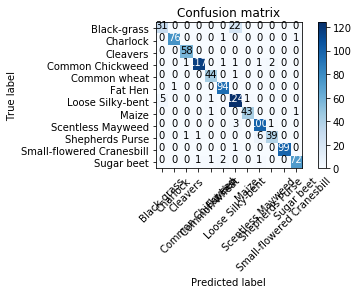

In [35]:
if (is_val):
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]

    cm = confusion_matrix(y, preds)

    plot_confusion_matrix(cm, data.classes)

Not bad at all

<h3>Make a submission</h3>

In [36]:
if not (is_val):
    log_preds, y = learn.TTA(is_test=True)
    probs = np.mean(np.exp(log_preds), 0)
    max_preds = np.argmax(probs, 1)
    class_preds = [data.classes[index_pred] for index_pred in max_preds]
    fnames_nopath = [fname[5:] for fname in data.test_ds.fnames]
    fname_preds = list(zip(fnames_nopath, class_preds))
    df = pd.DataFrame(fname_preds)
    df.columns = ['file', 'species']
    df.to_csv(f'{PATH}submission.csv', index=False)